In [1]:
import numpy as np
import pandas as pd 
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

#pd.options.display.max_rows = None
#pd.options.display.max_columns = None

# Basic Recommender Systems

We're going to use a dataset of games from the kaggle database, that is our system will recommend games to a user. We're essentially implementing the recommendation system found in RAWG API.

Let's load up some basic data to work with:

In [2]:
game = pd.read_csv('game_info.csv')

display(game.head(1))
print (game.shape)

,id,slug,name,metacritic,released,tba,updated,website,rating,rating_top,...,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing
0,1,dgeneration-hd,D/Generation HD,NaN,2015-10-23,False,2019-09-17T11:58:57,http://dgeneration.net,0.0,0,...,West Coast Software||West Coast Software Limited,Adventure||Puzzle,West Coast Software||West Coast Software Limited,Everyone 10+,3,70,0,2,0,0


(345667, 27)


# Cleaning

Take some steps to clean the data.
First, it needs to check for any null values.

In [3]:
game.isnull().sum()

id                           0
slug                         2
name                         2
metacritic              342428
released                 27201
tba                          0
updated                      0
website                 284812
rating                       0
rating_top                   0
playtime                     0
achievements_count           0
ratings_count                0
suggestions_count            0
game_series_count            0
reviews_count                0
platforms                 3391
developers                6236
genres                   67190
publishers              214606
esrb_rating             290551
added_status_yet             0
added_status_owned           0
added_status_beaten          0
added_status_toplay          0
added_status_dropped         0
added_status_playing         0
dtype: int64

80% of missing data can be a good threshold to drop the variable entirely.

Since, the feature name is very similar to slug. We can drop the duplicate feature. 

Dropping the missing data that less than 3% of the total obseravations, it doesn't make much of a difference in our approach.

In [4]:
# Dropping missing datas more than 80%
game.drop(['id','metacritic','released','esrb_rating',
           'updated','developers','publishers','website'],axis = 1,inplace = True)

# Dropping not meaningful data 
game.drop(['slug'],axis = 1,inplace = True)

# Dropping the game without name
game = game[~game['name'].isnull()].reset_index(drop=True)

We can replace any missing value with unknown for genres and platforms.

In [5]:
# Replace the missing value with unknown instead of Null value 
game['genres'] = game['genres'].fillna('unknown_genre')

game['platforms'] = game['platforms'].fillna('unknown_plat')

Double Check for any missing values

In [6]:
for i in range (0,len(game.isnull().sum())):
    if game.isnull().sum()[i] == 0:
        continue
    else:
        print('unclean')
print('clean')

clean


# Feature Engineering

We can do some feature engineering like making dummy variables. This takes a column, and creates a dataframe in which there is a column for each of the different categories in the original series. The values for the new columns will be 1 along the rows where that piece of data appeared, and 0 otherwise.

We want everything convert into integer variables. So that, it will help us speed up the progress later on.

In [7]:
genres = game['genres'].str.get_dummies('|')
platforms = game['platforms'].str.get_dummies('|')

game['tba'] = game['tba'].map({False: '0',True:'1'})

game['rating'] = round(game['rating']).astype(int)

In [8]:
game = game.join(genres)
game = game.join(platforms)
game.drop(['genres','platforms'],axis = 1,inplace = True)

In [9]:
game.head(5)

,name,tba,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,...,Web,Wii,Wii U,Xbox,Xbox 360,Xbox One,iOS,mac,macOS,unknown_plat
0,D/Generation HD,0,0,0,1,80,0,283,0,0,...,0,0,0,0,0,1,0,0,1,0
1,G Prime Into The Rain,0,0,0,0,26,0,375,0,0,...,0,0,0,0,0,1,0,0,1,0
2,Land Sliders,0,0,0,0,0,1,71,0,1,...,0,0,0,0,0,0,1,0,0,0
3,Pixel Gear,0,0,0,0,0,0,443,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Gods and Idols,0,0,0,1,0,4,268,0,4,...,0,0,0,0,0,0,0,0,0,0


# EDA

When conducting an EDA it is useful to have a sharp question to focus the analysis. 

In the first graph, it's a bar chart and shows the number of genres in each games. <br>
It shows that most of popluar genres are $1st-Action$, $2nd-Adventure$ and $3rd-Puzzle$.

      

In [10]:
genres_list = list(genres.columns.values.tolist())
genres_counts = []
for i in genres_list:
    count = game[i].value_counts()[1]
    genres_counts.append(count)

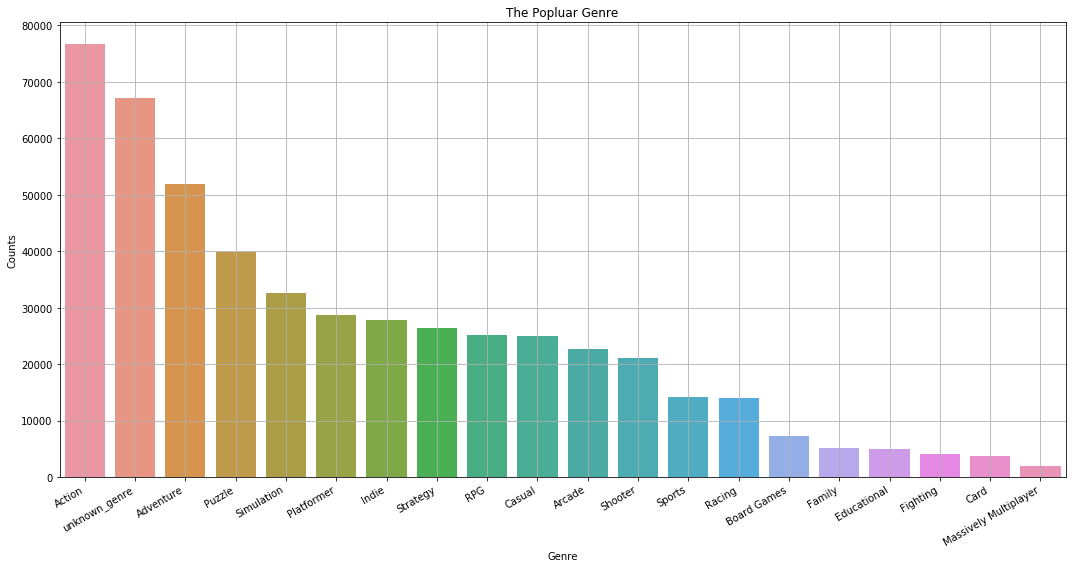

In [11]:
plot1 = pd.DataFrame({'Genre' : genres_list , 'Counts' : genres_counts})
plot1 = plot1.sort_values('Counts',ascending=False)
plt.figure(figsize = (15,8))
sns.barplot(x=plot1['Genre'], y=plot1['Counts']).set_title("The Popluar Genre")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

In the second graph, it's a bar chart and shows the number of platforms in each games. <br>
It shows that most of popluar platforms are $1st-PC$, $2nd-iOS$ and $3rd-Web$.

In [12]:
platforms_list = list(platforms.columns.values.tolist())
platforms_counts = []
for i in platforms_list:
    count = game[i].value_counts()[1]
    platforms_counts.append(count)

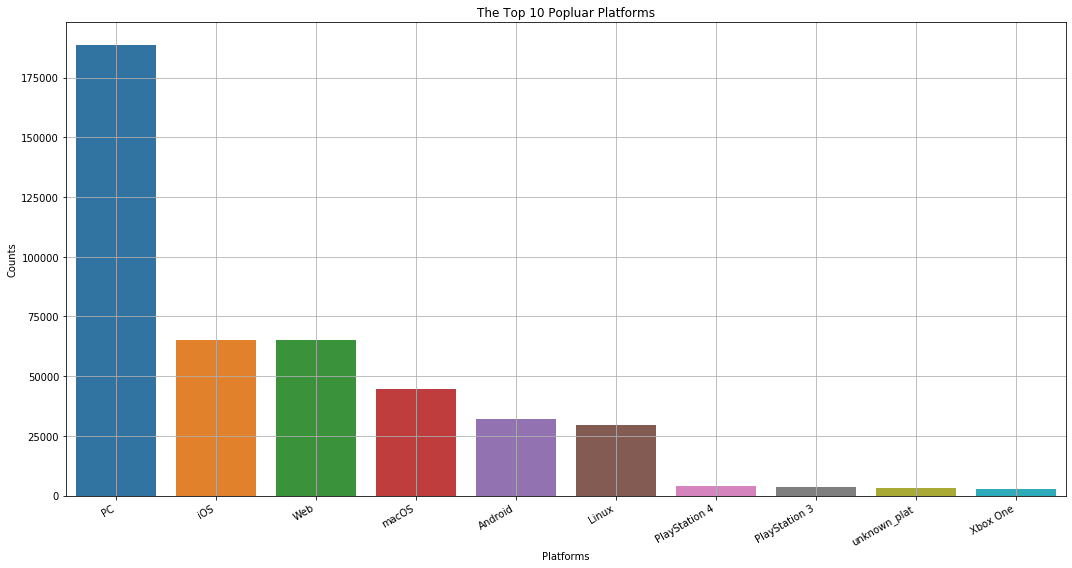

In [13]:
plot2 = pd.DataFrame({'Platforms' : platforms_list , 'Counts' : platforms_counts})
plot2 = plot2.sort_values('Counts',ascending=False)
plt.figure(figsize = (15,8))
sns.barplot(x=plot2['Platforms'][0:10], y=plot2['Counts'][0:10]).set_title("The Top 10 Popluar Platforms")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

In the third graph, it's a bar chart and shows the number of ratings in each games. <br>
Since, there is large amount of 0 rating. It creates an inbalance class. <br>
If we not include the rating 0 in the graph, it shows most of the games have the rating 4.

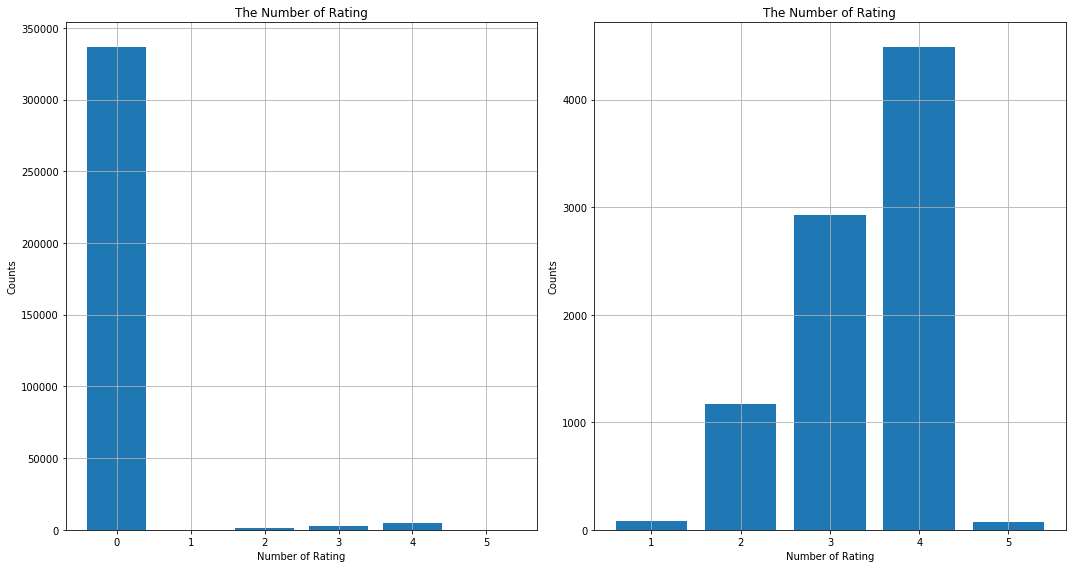

In [14]:
fig, ax = plt.subplots(1,2,figsize = (15,8))

ax[0].bar(game['rating'].value_counts().index, game['rating'].value_counts().values)

ax[1].bar(game['rating'].loc[game['rating'] != 0.0].value_counts().index, 
         game['rating'].loc[game['rating'] != 0.0].value_counts().values)


ax[0].set_title('The Number of Rating')
ax[1].set_title('The Number of Rating')
ax[0].set_xlabel('Number of Rating')
ax[1].set_xlabel('Number of Rating')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[0].grid()
ax[1].grid()
fig.tight_layout()
plt.show()

# A User Independent System

As a first attempt, let's build a system totally independent of user action, that is, it recommends a list of items that it thinks the average user would like.

The simplest system would just sort the items based on their average score and present a list in that order:

In [15]:
top_rated = game.sort_values(by=['rating'], ascending=False)
top_rated['name'].head(10)

309835                    PICROSS S2
308907                    God of War
306784                 NBA Street V3
310650             STEINS;GATE ELITE
306783             NBA Street Vol. 2
6192      GameMaker Studio 2 Desktop
291589                  Star Citizen
232737                      Supaplex
274150            Assemble with Care
168115                 Disco Elysium
Name: name, dtype: object

We want to ignore ratings with too few reviews. If we were to implement this with our data set: <br>
The list below shows that most of popluar game are $1st-The Witcher 3: Wild Hun$, $2nd-Portal 2$ and $3rd-God of War$.

In [16]:
top_rated_v2 = game.sort_values(by=['rating','reviews_count'], ascending=False)

top_rated_v2 = top_rated_v2.loc[top_rated_v2['reviews_count']>1500]

top_rated_v2.loc[:,['name','rating','reviews_count']].head(10)

,name,rating,reviews_count
238383,The Witcher 3: Wild Hunt,5,2462
291899,Portal 2,5,2337
308907,God of War,5,1783
185152,Red Dead Redemption 2,5,1646
152701,Uncharted 4: A Thief’s End,5,1591
250429,Grand Theft Auto V,4,2667
37736,Portal,4,1925
307488,The Elder Scrolls V: Skyrim,4,1924
290500,BioShock Infinite,4,1811
249486,Life is Strange,4,1615


Now, we want take a look at the top 3 games in the top 3 genres. <br>
The first list below shows that most of popluar action game are <br> $1st-God of War$, $2nd-Red Dead Redemption 2$ and $3rd-Uncharted 4: A Thief’s End$.

In [17]:
top_rated_action = game.sort_values(by=['rating','reviews_count'], ascending=False)

top_rated_action = top_rated_action.loc[(top_rated_action['reviews_count']>1500) & 
                                        (top_rated_action['Action'] == 1) ]

top_rated_action.loc[:,['name','rating','reviews_count','Action']].head(10)

,name,rating,reviews_count,Action
308907,God of War,5,1783,1
185152,Red Dead Redemption 2,5,1646,1
152701,Uncharted 4: A Thief’s End,5,1591,1
250429,Grand Theft Auto V,4,2667,1
37736,Portal,4,1925,1
307488,The Elder Scrolls V: Skyrim,4,1924,1
290500,BioShock Infinite,4,1811,1
37746,Half-Life 2,4,1602,1
183215,Horizon Zero Dawn,4,1587,1
152101,DOOM (2016),4,1548,1


The second list below shows that most of popluar adventure game are <br> $1st-Uncharted 4: A Thief’s End$, $2nd-The Last Of Us Remastered$ and $3rd-The Last Of Us$.

In [18]:
top_rated_adventure = game.sort_values(by=['rating','reviews_count'], ascending=False)

top_rated_adventure = top_rated_adventure.loc[(top_rated_adventure['reviews_count']>1000) & 
                                              (top_rated_adventure['Adventure'] == 1) ]

top_rated_adventure.loc[:,['name','rating','reviews_count','Action']].head(10)

,name,rating,reviews_count,Action
152701,Uncharted 4: A Thief’s End,5,1591,1
262130,The Last Of Us Remastered,5,1351,1
289746,The Last Of Us,5,1202,1
37736,Portal,4,1925,1
249486,Life is Strange,4,1615,0
303272,Tomb Raider (2013),4,1540,1
3152,Limbo,4,1459,1
132456,The Legend of Zelda: Breath of the Wild,4,1166,1
294545,Grand Theft Auto IV,4,1140,1
230646,Journey,4,1084,0


The third list below shows that most of popluar puzzle game are <br> $1st-Portal 2$, $2nd-Portal$ and $3rd-Limbo$.

In [19]:
top_rated_puzzle = game.sort_values(by=['rating','reviews_count'], ascending=False)

top_rated_puzzle = top_rated_puzzle.loc[(top_rated_puzzle['reviews_count']>450) & 
                                        (top_rated_puzzle['Puzzle'] == 1) ]

top_rated_puzzle.loc[:,['name','rating','reviews_count','Puzzle']].head(10)

,name,rating,reviews_count,Puzzle
291899,Portal 2,5,2337,1
37736,Portal,4,1925,1
3152,Limbo,4,1459,1
48088,INSIDE,4,1007,1
87897,Brothers - A Tale of Two Sons,4,787,1
38209,"Papers, Please",4,711,1
272882,FEZ,4,624,1
80840,Valiant Hearts: The Great War,4,577,1
192287,The Witness,4,553,1
284715,Trine 2: Complete Story,4,489,1


We see the recommendations have significantly changed.

However, <br>
If an item must meet a threshold to appear in a recommended list but it never appears in a list not many people will watch it. That is it will have a hard time getting the reviews it needs. Therefore, we need to more data and different user to rating the games (like collabative recommendation). 

# Data Analysis

Now, we need do some feature selection and to take a look at the highlight correlation table for what is doing on in the dataframe.

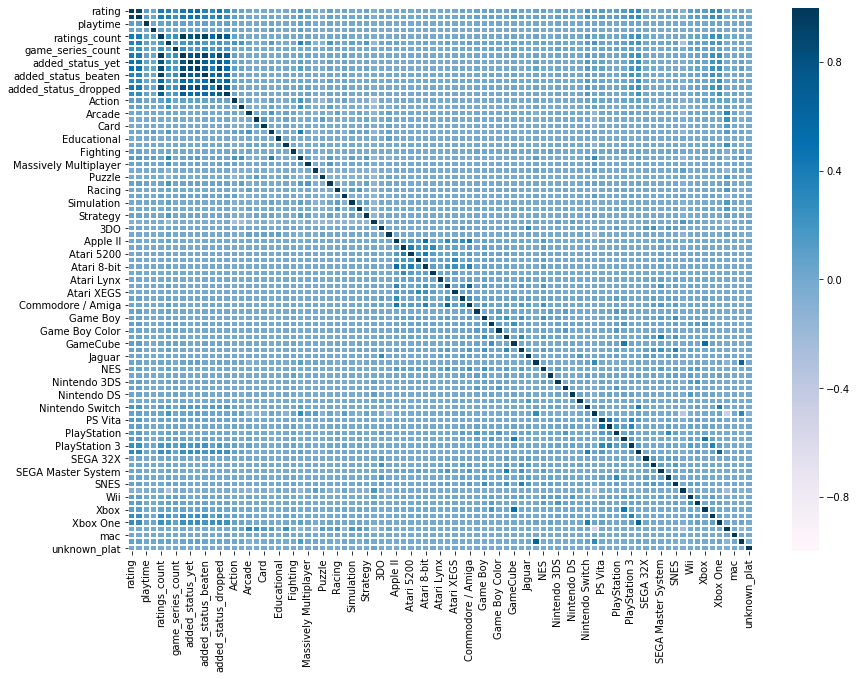

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax=sns.heatmap(game.corr(), vmin=-1, vmax=1, cmap="PuBu", linewidths=1)

To do so, we need to follow the procedure steps for the model.

    STEP: Check the correlation > Apply VIF > Check for the coefficient and p - value
    
First, we need to drop all the columns that the correlation inbetween -0.3 to 0.3.

In [21]:
game.corr()[['rating']].query('rating >= 0.3 or rating <= -0.3').style.background_gradient(cmap="PuBu")  

,rating
rating,1
rating_top,0.935971
ratings_count,0.417017
suggestions_count,0.351649
reviews_count,0.417152
added_status_yet,0.473819
added_status_owned,0.500076
added_status_beaten,0.351428
added_status_dropped,0.436792


Here, it's the data point and it separated into independent and dependent.

In [22]:
# Original List of features
#'rating_top','ratings_count','suggestions_count','reviews_count',
#     'added_status_yet','added_status_owned','added_status_beaten',
#     'added_status_toplay','added_status_dropped'

X = game[['rating_top','suggestions_count',
     'added_status_yet',
     'added_status_dropped']]
y = game['rating']

In [23]:
X_withconst = sm.add_constant(X)
sm.OLS(y, X_withconst).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 6.305e+05
Date:                Wed, 15 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:35:15   Log-Likelihood:                 85538.
No. Observations:              345665   AIC:                        -1.711e+05
Df Residuals:                  345660   BIC:                        -1.710e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0038      0.000     -8.853      0.000      -0.005      -0.003
rating_top               0.7965      0.001   1288.660      0.000       0.795       0.798
suggestions_count      6.61e-05   2.91e-06     22.738      0.000    6.04e-05    7.18e-05
added_status_yet         0.0041   8.29e-05     49.003      0.000       0.004       0.004
added_status_dropped     0.0018    6.9e-05     26.302      0.000       0.002       0.002
==============================================================================
Omnibus:                   532254.146   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        614108016.920
Skew:                          -9.448   Prob(JB):                         0.00
Kurtosis:                     208.624   Cond. No.                         306.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we need to apply VIF for some cleaning. <br>
The result below is already finish cleaning.


In [24]:
ans = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])], 
              index= X.columns)

We want to find if there is any multicollinearity. <br>

The first signs of multicollinearity can be detected in the correlation between the predictors. If a regression model is to be fitted, this should always be part of the exploratory phase. If the correlation between some predictors is high, it is a sign of multicollinearity.The Variance Inflation Factor (VIF) is calculated for each predictor.

So, we need to drop any VIF value that is over 5. <br>
Then, we need to drop any p - value that is over 0.05.

In [25]:
ans.sort_values(ascending = False).apply(lambda x: '%.5f' % x)

added_status_yet        2.34043
added_status_dropped    2.24685
rating_top              1.42660
suggestions_count       1.16480
dtype: object

Here,it's result that we need to drop the features.

VIF

        ratings_count           38600.87168
        reviews_count           44.15528
        added_status_owned      10.72255
        
p - value

        added_status_beaten	1.406e-05	2.33e-05	0.603	0.546	-3.16e-05	5.97e-05
        added_status_toplay	-9.592e-05	6.34e-05	-1.512	0.131	-0.000	2.84e-05
        
Notes: Even I dropped so many columns the R - squared still remain in 0.879 and 0.879 is pretty good value.

In [26]:
X_withconst = sm.add_constant(X)
linear_reg = sm.OLS(y, X_withconst).fit()
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 6.305e+05
Date:                Wed, 15 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:35:15   Log-Likelihood:                 85538.
No. Observations:              345665   AIC:                        -1.711e+05
Df Residuals:                  345660   BIC:                        -1.710e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0038      0.000     -8.853      0.000      -0.005      -0.003
rating_top               0.7965      0.001   1288.660      0.000       0.795       0.798
suggestions_count      6.61e-05   2.91e-06     22.738      0.000    6.04e-05    7.18e-05
added_status_yet         0.0041   8.29e-05     49.003      0.000       0.004       0.004
added_status_dropped     0.0018    6.9e-05     26.302      0.000       0.002       0.002
==============================================================================
Omnibus:                   532254.146   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        614108016.920
Skew:                          -9.448   Prob(JB):                         0.00
Kurtosis:                     208.624   Cond. No.                         306.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After we remove multicollinearity and find the highlight correlation, we want to visualize the plot between
$rating$,$rating top$,$suggestions count$,$added status yet$ and $added status dropped$ check if it follows a linear relationship.

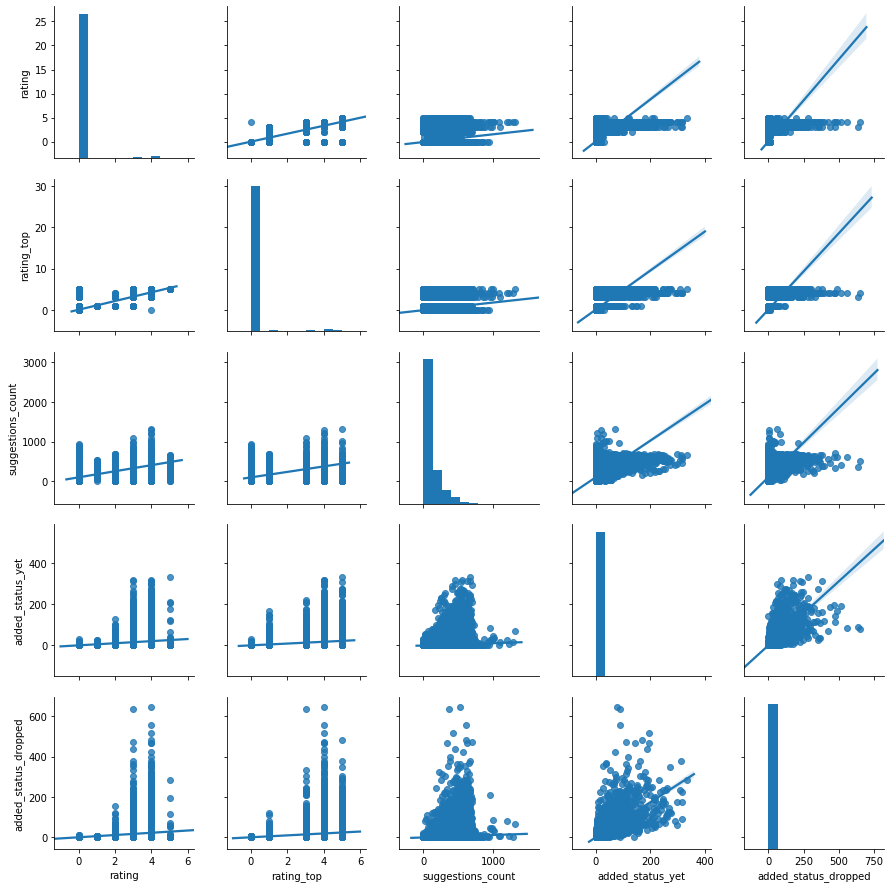

In [27]:
sns.pairplot(game[['rating','rating_top','suggestions_count',
                   'added_status_yet','added_status_dropped']],kind="reg");
plt.show()

We discovered well reviewed the majority rating top is $2$, the higher suggestions count the higher rating and it seem like added status & added status dropped have very similar correlation with rating. 

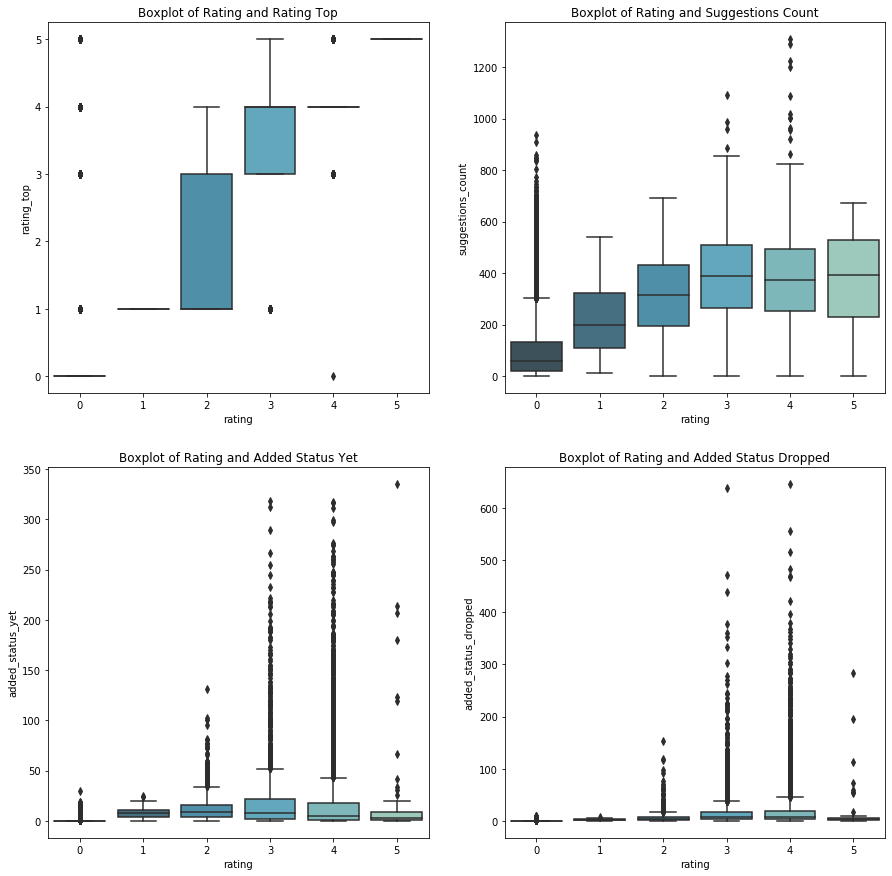

In [28]:
fig, axs = plt.subplots(2,2,figsize=(15, 15))
sns.boxplot(x='rating',y='rating_top',data=game,palette='GnBu_d',
            ax=axs[0,0]).set_title("Boxplot of Rating and Rating Top")

sns.boxplot(x='rating',y='suggestions_count',data=game,palette='GnBu_d',
            ax=axs[0,1]).set_title("Boxplot of Rating and Suggestions Count")

sns.boxplot(x='rating',y='added_status_yet',data=game,palette='GnBu_d',
            ax=axs[1,0]).set_title("Boxplot of Rating and Added Status Yet")

sns.boxplot(x='rating',y='added_status_dropped',data=game,palette='GnBu_d',
            ax=axs[1,1]).set_title("Boxplot of Rating and Added Status Dropped")



plt.show()

# Modeling

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

Once we have our data set up, and split into the target and features, we can begin fitting our model. Fitting a model just means we learn how the target arises from the features.

In [30]:
X = game[['rating_top','suggestions_count',
     'added_status_yet','added_status_dropped']]
y = game['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

We'll be using Scikit-Learn logistic regression to train our model. <br>
Although there is a small overfitting, the result looks pretty well with the score around $98$ %. 

In [31]:
logreg = LogisticRegression(solver = 'lbfgs',multi_class='auto')
logreg.fit(X_train, y_train)

print(f'The accuracy score on the train set: {logreg.score(X_train,y_train)}')
print(f'The accuracy score on the test set: {logreg.score(X_test,y_test)}')

The accuracy score on the train set: 0.9845266877440952
The accuracy score on the test set: 0.9844840887174542


Then , we'll be try to use a random forest classifier to train our model. <br>
Unfortunately, there is a very strong overfitting with randomm forest classifier and improved the accuracy score around $1$ %.

In [32]:
my_random_forest = RandomForestClassifier(n_estimators=30)
my_random_forest.fit(X_train, y_train)

print(f'The accuracy score on the train set: {my_random_forest.score(X_train,y_train)}')
print(f'The accuracy score on the test set: {my_random_forest.score(X_test,y_test)}')

The accuracy score on the train set: 0.9996693736697456
The accuracy score on the test set: 0.9894117647058823


The confusion matrix plots below show that the Game model has very significant result of predicting only when rating is equal to 0. <br>

Why so? 

In [33]:
preds = logreg.predict(X_test)
con_mat = confusion_matrix(y_test,preds)
con_mat

array([[100783,      0,     46,     81,    148,      4],
       [     9,      0,      1,     10,     11,      0],
       [    58,      0,     14,    136,    146,      0],
       [    79,      0,      6,    158,    628,      0],
       [   106,      0,      1,    112,   1136,      0],
       [     8,      0,      0,      0,     19,      0]])

In [34]:
df_con_mat = pd.DataFrame(con_mat, 
                          columns = ['Predicted 0','Predicted 1',
                                     'Predicted 2','Predicted 3',
                                     'Predicted 4','Predicted 5'],
                          index = ['True 0','True 1',
                                   'True 2','True 3',
                                   'True 4','True 5'])

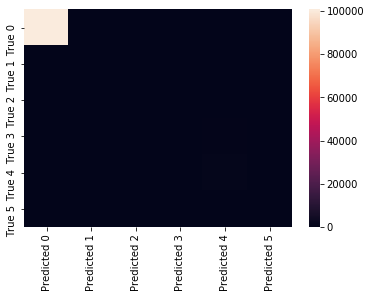

In [35]:
plt.figure()
sns.heatmap(df_con_mat)
plt.show()

# Conclusion and Future Plan

In summary, the reason the model has a very high accuary score and predicting the rating on 0 is very high is because they have an imbalance data set. The majority of this dataset doesn't have enough rating. So, the future works on this problem is to find more others user to rating each games and add more feature like overview of the game for text mining. Also, we can try to use neural network to improve our result/prediction.